# Imports

In [1]:
%%capture
!chmod -R 777 ../

In [3]:
# System and path operations
import sys
import os
import datetime
from pathlib import Path
from glob import glob
sys.path.insert(0, '../') 

# Imported local modules
from src.config import *
from src.utils import *
from src.models_arch import *
from src.models_utils import *

# Basic python data handling and visualization libraries
import random
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time

# Libraries for image processing
from PIL import Image
import skimage
from skimage.io import imread, imsave
import tifffile as tiff

# Libraries for model evaluation and validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, jaccard_score, roc_curve, auc

# TensorFlow and Keras libraries for deep learning
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import keras
from keras import backend as K
from keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau, 
                             CSVLogger, EarlyStopping)
from keras.utils import Sequence

# Setting seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
# Setting GPU's number
physical_devices=tf.config.experimental.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [4]:
# tf.config.set_visible_devices(physical_devices[:],'GPU')
tf.config.set_visible_devices(physical_devices[3],'GPU')

In [5]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard
# %tensorboard --logdir logs/fit 

In [6]:
# Clear any logs from previous runs
# !rm -rf ../logs/
# !rm -rf ../models/

---

# Hyperparameter Selection and Model Configuration

In the following code snippet, we focus on the essential aspects of configuring a deep learning model for a specific task. The primary objective is to select appropriate hyperparameters and set up the model for training.

### Model Selection

The code allows for the selection of various deep learning models, including 'UNet', 'RSNet', 'UNetPlusPlus', 'CloudNet', 'CloudXNet', 'RSNet', and 'DLV3'. These models are tailored for different computer vision tasks, and here we prepare to use one of them as the foundation for our task.

Available models:
- 'unet'
- 'unet_plus_plus'
- 'rs_net'
- 'deep_lab_v3_plus'
- 'CXNet'
- 'cloud_net'

### Batch Size and Data Configuration

The batch size, a crucial hyperparameter that affects training efficiency and memory consumption, is set to 16. Additionally, there's an option to specify whether the training data includes RGB channels or both RGB and NIR channels, denoted as 'RGB' or 'RGBNIR', respectively.

### Learning Rate and Optimization

The learning rate, an essential hyperparameter for controlling the step size during optimization, is set to 1e-4. Different optimizers such as Adam, Nadam, SGD, and RMSprop are available for selection, each with its impact on training dynamics.

### Loss and Metrics

The code provides flexibility in choosing the loss function and evaluation metrics. Options include 'binary_crossentropy', 'BinaryFocalCrossentropy', custom loss functions like 'bce_dice_loss' and 'jacc_coef', as well as metrics such as 'AUC'.

### Model Initialization

The selected model is initialized using the chosen hyperparameters and configurations, setting the stage for further model training and evaluation.

---
Notes:
- DeepLabV3+, CXNen need resizing since a fixed image size is required for internal operations
- DeepLabV3+ and CXNet can only be trained with 3 channel images(RGB in our case) due to internal operations

In [7]:
# model_name = 'RSNet'
# model_name = 'UNetPlusPlus'
model_name = 'CloudNet'
# model_name = 'CloudXNet'
# model_name = 'RSNet'
# model_name = 'DLV3'
# model_name = 'UNet'

# Define batch size
batch_size = 16

# Define if training with RGB or RGBNIR images
train_with_RGB = True

# learning rate
LR = 1e-4

# Define number of epochs
NUM_EPOCHS=100

In [8]:
s = 'RGB' if train_with_RGB else 'RGBNIR'

model_name = f'{model_name}_biome8_epochs{NUM_EPOCHS}_batch{batch_size}_{s}'

model_name

'CloudNet_biome8_epochs100_batch16_RGB'

In [9]:
# Set the model optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
# optimizer = tf.keras.optimizers.Nadam(learning_rate=LR)
# optimizer = tf.keras.optimizers.SGD(learning_rate=LR)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=LR)

metrics = ['binary_crossentropy', tf.keras.losses.BinaryFocalCrossentropy(), bce_dice_loss, jacc_coef, tf.keras.metrics.AUC()]
# metrics = [jacc_coef, tf.keras.metrics.AUC()]


# loss = 'binary_crossentropy'
loss = jacc_coef
# loss = tf.keras.losses.BinaryFocalCrossentropy()
# loss = bce_dice_loss

# model = create_model(model_name='CXNet', IMG_HEIGHT=256 , IMG_WIDTH=256, IMG_CHANNELS=3)
# model = create_model(model_name='deep_lab_v3_plus', IMG_HEIGHT=256 , IMG_WIDTH=256, IMG_CHANNELS=3)
# model = create_model(model_name='unet_plus_plus')
# model = create_model(model_name='unet')
model = create_model(model_name='cloud_net', IMG_CHANNELS=3)

2023-08-30 22:38:38.336419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 22:38:38.804925: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22311 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c2:00.0, compute capability: 8.6


# Data loading

In [10]:
train_image_names = sorted(os.listdir(Path(biome_train_dir, "images_p/")))
valid_image_names = sorted(os.listdir(Path(biome_valid_dir, "images_p/")))

# steps_per_epoch = len(train_image_names) // batch_size
# validation_steps = len(valid_image_names) // batch_size

steps_per_epoch = math.ceil(len(train_image_names) / batch_size)
validation_steps = math.ceil(len(valid_image_names) / batch_size)

steps_per_epoch, validation_steps

(1087, 121)

In [11]:
test_image_names = sorted(os.listdir(Path(biome_test_dir, "images_p/")))
total_test_samples = math.ceil(len(test_image_names) / batch_size)

In [12]:
train = get_biome8_generator('train', batch_size=batch_size, shuffle=True, only_rgb=train_with_RGB)
valid = get_biome8_generator('valid', batch_size=batch_size, only_rgb=train_with_RGB)
# valid = get_SPARCS_generator('train', batch_size=batch_size, only_rgb=train_with_RGB)
test = get_biome8_generator('test', batch_size=batch_size, only_rgb=train_with_RGB)

In [13]:
X_test, y_test = get_biome8('test', only_rgb=train_with_RGB)

Loading data: 100%|██████████| 3714/3714 [00:09<00:00, 407.97it/s]


# Training

---

## Checkpoint and Callback Configuration

In this code segment, we configure essential aspects related to saving checkpoints and defining callbacks during the training of a deep learning model. These components are crucial for monitoring and optimizing the training process.

### Checkpoint Configuration

Checkpointing is essential to save the model's progress during training. This code defines checkpoint paths using `ckpt_path` and sets up the directory for saving checkpoints. A common practice is to save the best model based on validation loss. Thus, a ModelCheckpoint callback (`cp_callback`) is established to monitor the validation loss and save only the best-performing model weights.

### Logging and TensorBoard

The code also establishes a directory for logging training information using TensorBoard. This log directory, `log_dir`, includes details about model performance during training, such as loss curves and metrics over epochs. A TensorBoard callback (`tensorboard_callback`) is created to facilitate this logging.

### Time Tracking Callback

To keep track of the time taken for each training epoch, a custom callback named `TimeHistory` is defined. This callback records the time spent on each epoch, providing insights into the training duration.

### Early Stopping

Early stopping is a useful technique to prevent overfitting. An EarlyStopping callback (`early_stopping`) is set up to monitor the validation loss and halt training if it does not improve for a specified number of epochs (patience).

### Learning Rate Scheduling

Learning rate scheduling is incorporated via a ReduceLROnPlateau callback (`reduce_lr`). This callback monitors the validation loss and adjusts the learning rate during training to help converge to a better solution.

### Callbacks List

Finally, all defined callbacks (`cp_callback`, `time_callback`, `tensorboard_callback`, `reduce_lr`) are assembled into a list called `callbacks_list`. This list is then used during model training to execute the specified actions at different training stages.

---

These checkpointing and callback configurations are essential for effectively monitoring and managing the training process of deep learning models, ensuring that the best model is saved and providing valuable insights into training dynamics and performance.

In [14]:
# Include the epoch in the file name (uses `str.format`)
# ckpt_path = str(checkpoint_path / f"{model_name}/" / "cp-{epoch:04d}.ckpt")
ckpt_path = str(checkpoint_path / f"{model_name}/" / "best_model.ckpt")

ckpt_dir = os.path.dirname(ckpt_path)

log_dir = project_root_path / "logs/fit/" / model_name / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Checkpoint callbacks definition
# Save the checkpoint only if the validation loss is minimum
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path, 
    verbose=1, 
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_weights_only=True,
    save_freq='epoch')

# Time callback definition
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
time_callback = TimeHistory()

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Define the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, cooldown=0, patience=15, min_lr=1e-8, verbose=1)

In [15]:
# callbacks_list = [cp_callback, time_callback, tensorboard_callback, early_stopping, reduce_lr]
callbacks_list = [cp_callback, time_callback, tensorboard_callback, reduce_lr]

In [16]:
# Save the weights using the `checkpoint_path` format
model.save_weights(ckpt_path.format(epoch=0))

In [17]:
# Resume from checkpoint

# # Create a new model instance
# model = create_model(model_name='unet_plus_plus')

# # Try to load the latest checkpoint
# try:
#     latest = tf.train.latest_checkpoint(ckpt_dir)
#     latest_epoch = int(latest.split("-")[-1].split(".")[0])  # extract epoch number from the filename
#     model.load_weights(latest)
#     print(f"Loaded weights from {latest}")
# except Exception as e:
#     print("No checkpoint was found, starting training from scratch.")
#     latest_epoch = 0  # if no checkpoint was found, start from epoch 0

# # Now compile your model with optimizer and loss
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')  

# # Continue training the model
# # Here, epochs should be the final epoch number you want to reach and initial_epoch should be set to the epoch number where training last left off
# model.fit(train_dataset, epochs=total_epochs, initial_epoch=latest_epoch, callbacks=callbacks_list, validation_data=val_dataset)

## Tuner
Section used for the hyperparameter optimization of the model, it implements a simple grid search that tries a series of combinations and compute a score on the test set. The parameters of the model with the best score is printed.

Note: this section of code can be skipped if we alredy know the parameter of the model, otherwise you can easly setup the below parameters and perform the search.  

In [19]:
callbacks_list = [reduce_lr, early_stopping]

In [21]:
train_with_RGB = True

In [22]:
train_image_names = sorted(os.listdir(Path(biome_train_dir, "images_p/")))
valid_image_names = sorted(os.listdir(Path(biome_valid_dir, "images_p/")))

# steps_per_epoch = len(train_image_names) // batch_size
# validation_steps = len(valid_image_names) // batch_size

steps_per_epoch = math.ceil(len(train_image_names) / batch_size)
validation_steps = math.ceil(len(valid_image_names) / batch_size)

steps_per_epoch, validation_steps

(1087, 121)

In [23]:
def load(batch_size):
    train = get_biome8_generator('train', batch_size=batch_size, shuffle=True, only_rgb=train_with_RGB)
    valid = get_biome8_generator('valid', batch_size=batch_size, only_rgb=train_with_RGB)
    # valid = get_SPARCS_generator('train', batch_size=batch_size, only_rgb=train_with_RGB)
    test = get_biome8_generator('test', batch_size=batch_size, only_rgb=train_with_RGB)
    return train, valid, test

In [ ]:
from itertools import product
import numpy as np
from sklearn.metrics import jaccard_score

def train_and_evaluate_model(model, train_data, valid_data, NUM_EPOCHS):
    history = model.fit(train_data,
                    validation_data=valid_data,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=callbacks_list,
                    epochs=NUM_EPOCHS, 
                    verbose=1,)
    return history

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_thresholded = y_pred > 0.5

    y_true_f = y_test.astype('float32')
    y_pred_f = y_pred_thresholded.astype('float32')

    y_true_flatten = y_true_f.reshape(-1)
    y_pred_flatten = y_pred_f.reshape(-1)

    jaccard = jaccard_score(y_true_flatten, y_pred_flatten)
    return jaccard

def hyperparameter_search():
    # optimizer_options = [tf.keras.optimizers.Adam, tf.keras.optimizers.Nadam, tf.keras.optimizers.SGD, tf.keras.optimizers.RMSprop]
    # loss_options = ['binary_crossentropy', 'binary_focal_crossentropy', bce_dice_loss, jacc_coef]
    # learning_rates = [1e-4, 1e-3, 1e-2]
    # batch_sizes = [8, 16, 32]
    # num_epochs_list = [100, 200, 500]
    optimizer_options = [tf.keras.optimizers.Nadam]
    loss_options = ['binary_crossentropy', 'binary_focal_crossentropy', bce_dice_loss, jacc_coef]
    learning_rates = [1e-3]
    # batch_sizes = [8, 16, 32]
    batch_sizes = [8, 16]
    num_epochs_list = [20]

    best_jaccard = 0.0
    best_hyperparameters = {}

    for optimizer_class, loss_option, lr, batch_size, num_epochs in product(optimizer_options, loss_options, learning_rates, batch_sizes, num_epochs_list):
        optimizer = optimizer_class(learning_rate=lr)
        loss = loss_option
        
        train_data, valid_data, _ = load(batch_size)
        X_test, y_test = get_biome8('test', only_rgb=train_with_RGB)
        # X_test, y_test = get_SPARCS('test', only_rgb=train_with_RGB)


        model_name = f'CustomModel_optimizer_{optimizer_class.__name__}_loss_{loss}_lr_{lr}_batch_{batch_size}_epochs_{num_epochs}'
        print("Started training model: ", model_name)
        
        model = create_model(model_name='CXNet', IMG_HEIGHT=256 , IMG_WIDTH=256, IMG_CHANNELS=3)
        # model = create_model(model_name='deep_lab_v3_plus', IMG_HEIGHT=256 , IMG_WIDTH=256, IMG_CHANNELS=3)
        # model = create_model(model_name='unet_plus_plus')
        # model = create_model(model_name='rs_net')
        # model = create_model(model_name='cloud_net')
        model = compile_model(model, optimizer=optimizer, loss=loss)

        history = train_and_evaluate_model(model, train_data, valid_data, num_epochs)

        jaccard = evaluate_model(model, X_test, y_test)
        if jaccard > best_jaccard:
            best_jaccard = jaccard
            best_hyperparameters = {
                'name': model_name,
                'optimizer': optimizer_class.__name__,
                'loss': loss,
                'learning_rate': lr,
                'batch_size': batch_size,
                'num_epochs': num_epochs
            }
            
        print(f"Finished training model: {model_name} with score: {jaccard}. Best score:{best_jaccard}")

    return best_hyperparameters, best_jaccard

# Call the hyperparameter search function
best_hyperparameters, best_jaccard = hyperparameter_search()

Loading data: 100%|██████████| 3714/3714 [00:40<00:00, 91.85it/s] 


Started training model:  CustomModel_optimizer_Nadam_loss_binary_crossentropy_lr_0.001_batch_8_epochs_20
Epoch 1/20
1087/1087 [==============================] - 348s 308ms/step - loss: 0.4551 - auc_9: 0.8662 - val_loss: 0.6397 - val_auc_9: 0.8431 - lr: 0.0010
Epoch 2/20
1087/1087 [==============================] - 455s 418ms/step - loss: 0.3592 - auc_9: 0.9201 - val_loss: 0.1869 - val_auc_9: 0.9915 - lr: 0.0010
Epoch 3/20
1087/1087 [==============================] - 303s 279ms/step - loss: 0.2902 - auc_9: 0.9481 - val_loss: 0.3455 - val_auc_9: 0.9834 - lr: 0.0010
Epoch 4/20
1087/1087 [==============================] - 304s 280ms/step - loss: 0.2406 - auc_9: 0.9636 - val_loss: 0.2312 - val_auc_9: 0.9681 - lr: 0.0010
Epoch 5/20
1087/1087 [==============================] - 305s 281ms/step - loss: 0.2169 - auc_9: 0.9707 - val_loss: 0.1067 - val_auc_9: 0.9877 - lr: 0.0010
Epoch 6/20
1087/1087 [==============================] - 304s 280ms/step - loss: 0.1910 - auc_9: 0.9766 - val_loss: 0.224

Loading data: 100%|██████████| 3714/3714 [01:36<00:00, 38.31it/s] 


Started training model:  CustomModel_optimizer_Nadam_loss_binary_crossentropy_lr_0.001_batch_16_epochs_20
Epoch 1/20
1087/1087 [==============================] - 581s 523ms/step - loss: 0.3561 - auc_10: 0.9212 - val_loss: 0.2716 - val_auc_10: 0.9647 - lr: 0.0010
Epoch 2/20
1087/1087 [==============================] - 568s 522ms/step - loss: 0.2508 - auc_10: 0.9614 - val_loss: 0.1593 - val_auc_10: 0.9913 - lr: 0.0010
Epoch 3/20
1087/1087 [==============================] - 568s 523ms/step - loss: 0.1957 - auc_10: 0.9764 - val_loss: 0.2183 - val_auc_10: 0.9850 - lr: 0.0010
Epoch 4/20
1087/1087 [==============================] - 568s 523ms/step - loss: 0.1792 - auc_10: 0.9800 - val_loss: 0.7158 - val_auc_10: 0.9144 - lr: 0.0010
Epoch 5/20
1087/1087 [==============================] - 568s 522ms/step - loss: 0.1603 - auc_10: 0.9840 - val_loss: 0.6213 - val_auc_10: 0.9249 - lr: 0.0010
Epoch 6/20
1087/1087 [==============================] - 567s 521ms/step - loss: 0.1474 - auc_10: 0.9864 - val

Loading data: 100%|██████████| 3714/3714 [00:08<00:00, 440.46it/s]


Started training model:  CustomModel_optimizer_Nadam_loss_binary_focal_crossentropy_lr_0.001_batch_8_epochs_20
Epoch 1/20
1087/1087 [==============================] - 320s 282ms/step - loss: 0.1165 - auc_11: 0.8773 - val_loss: 0.1496 - val_auc_11: 0.9643 - lr: 0.0010
Epoch 2/20
1087/1087 [==============================] - 304s 280ms/step - loss: 0.0841 - auc_11: 0.9372 - val_loss: 0.0838 - val_auc_11: 0.9616 - lr: 0.0010
Epoch 3/20
1087/1087 [==============================] - 305s 281ms/step - loss: 0.0705 - auc_11: 0.9566 - val_loss: 0.3281 - val_auc_11: 0.7595 - lr: 0.0010
Epoch 4/20
1087/1087 [==============================] - 305s 281ms/step - loss: 0.0617 - auc_11: 0.9667 - val_loss: 0.1621 - val_auc_11: 0.9818 - lr: 0.0010
Epoch 5/20
1087/1087 [==============================] - 306s 281ms/step - loss: 0.0577 - auc_11: 0.9706 - val_loss: 0.1533 - val_auc_11: 0.9860 - lr: 0.0010
Epoch 6/20
1087/1087 [==============================] - 305s 281ms/step - loss: 0.0535 - auc_11: 0.9748 

In [ ]:
print("Best Hyperparameters:")
print(best_hyperparameters)
print("Best Jaccard Score:", best_jaccard)

# RS-net best:
# Best Hyperparameters:
# {'name': 'CustomModel_optimizer_Adam_loss_<function jacc_coef at 0x7f0c7bff3e50>_lr_0.001_batch_8_epochs_20', 'optimizer': 'Adam', 'loss': <function jacc_coef at 0x7f0c7bff3e50>, 'learning_rate': 0.001, 'batch_size': 8, 'num_epochs': 20}
# Best Jaccard Score: 0.8735452629473787
# Finished training model: CustomModel_optimizer_Adam_loss_<function bce_dice_loss at 0x7f0c7bff3b80>_lr_0.001_batch_16_epochs_20 with score: 0.8551185187375495. Best score:0.8558768982145087
# Finished training model: CustomModel_optimizer_Adam_loss_binary_crossentropy_lr_0.001_batch_32_epochs_20 with score: 0.8558768982145087. Best score:0.8558768982145087

# U-net++:
# Best Hyperparameters:
# {'name': 'CustomModel_optimizer_SGD_loss_binary_crossentropy_lr_0.001_batch_16_epochs_20', 'optimizer': 'SGD', 'loss': 'binary_crossentropy', 'learning_rate': 0.001, 'batch_size': 16, 'num_epochs': 20}
# Best Jaccard Score: 0.8506563442242354
# Finished training model: CustomModel_optimizer_Nadam_loss_binary_crossentropy_lr_0.001_batch_16_epochs_20 with score: 0.8221097807306096. Best score:0.8221097807306096

# DLV3+:
# Best Hyperparameters:
# {'name': 'CustomModel_optimizer_Nadam_loss_binary_focal_crossentropy_lr_0.001_batch_8_epochs_20', 'optimizer': 'Nadam', 'loss': 'binary_focal_crossentropy', 'learning_rate': 0.001, 'batch_size': 8, 'num_epochs': 20}
# Best Jaccard Score: 0.8420733385158327

# cloud-net:
# Best Hyperparameters:
# {'name': 'CustomModel_optimizer_Nadam_loss_binary_crossentropy_lr_0.001_batch_16_epochs_20', 'optimizer': 'Nadam', 'loss': 'binary_crossentropy', 'learning_rate': 0.001, 'batch_size': 16, 'num_epochs': 20}
# Best Jaccard Score: 0.8906706369653524
# Finished training model: CustomModel_optimizer_Nadam_loss_<function jacc_coef at 0x7f44def8c8b0>_lr_0.001_batch_16_epochs_20 with score: 0.8649839533303364.

## Compile

In [ ]:
model = compile_model(model, optimizer=optimizer, metrics=metrics, loss=loss)

model.summary()

## Fit

In [ ]:
# # Train the model and save the history
# history = model.fit(train,
#                     epochs=5,
#                     validation_data=valid,
#                     callbacks=[cp_callback, time_callback],
#                     verbose=1)

# Train the model and save the history. Generator version
history = model.fit(train,
                    validation_data=valid,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=callbacks_list,
                    epochs=NUM_EPOCHS, 
                    verbose=1,)

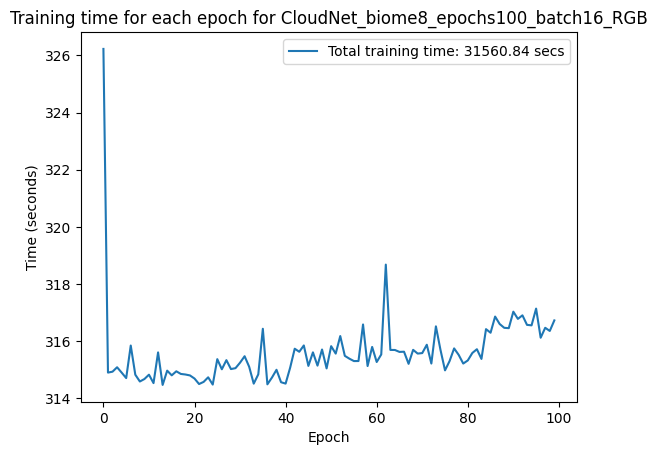

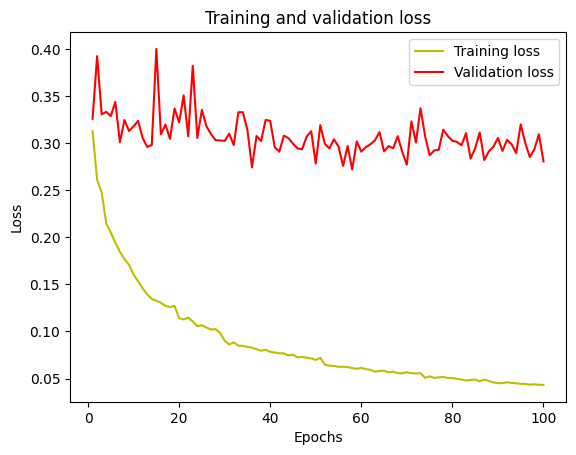

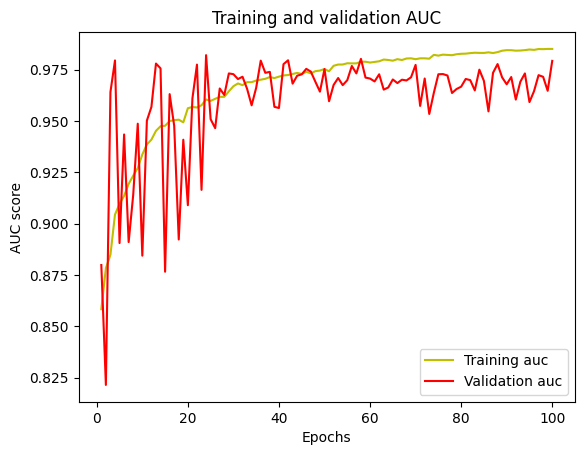

In [22]:
plt.plot(time_callback.times, label=f'Total training time: {sum(time_callback.times):.2f} secs')
plt.ylabel('Time (seconds)')
plt.xlabel('Epoch')
plt.title(f'Training time for each epoch for {model_name}')
plt.legend()  # This displays the legend

# Save the figure
plt.savefig(os.path.join(log_dir, 'training_time.png'))

plt.show()

#plot the training and validation metric and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title(f'Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the figure
plt.savefig(os.path.join(log_dir, 'loss.png'))

plt.show()

acc = history.history['auc']
val_acc = history.history['val_auc']
plt.plot(epochs, acc, 'y', label='Training auc')
plt.plot(epochs, val_acc, 'r', label='Validation auc')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC score')
plt.legend()

# Save the figure
plt.savefig(os.path.join(log_dir, 'auc.png'))

plt.show()

## Save

In [31]:
# Convert float32 values to float
def convert_float32_to_float(obj):
    if isinstance(obj, np.float32):
        return float(obj)
    return obj

In [32]:
# model.save(Path(saved_models_path, model_name))
model.save(Path(saved_models_path, f"{model_name}.h5"))

# Save training history
with open(Path(train_history_path, f'{model_name}.json'), 'w') as f:
    json.dump(history.history, f, default=convert_float32_to_float)

---

## Evaluation and Visualization of Model Performance

In the following code segment, we delve into the evaluation and visualization of a deep learning model's performance, particularly in the context of binary image segmentation tasks. The code includes the calculation of metrics such as the Jaccard Score (Intersection over Union or IoU) and the Receiver Operating Characteristic (ROC) curve. Additionally, it explores the impact of different threshold values on segmentation performance.

### Model Predictions and Thresholding

The code begins by making predictions using the trained model on a test dataset (`X_test`) and then applies a threshold of 0.5 to these predictions, converting them into binary masks (`y_pred_thresholded`). This thresholding step is a common practice in binary image segmentation tasks.

### Jaccard Score (IoU)

The Jaccard Score, also known as the IoU, is a crucial metric for evaluating segmentation accuracy. The code computes this score by comparing the flattened ground truth (`y_true`) and thresholded predicted masks (`thresholded_predictions`). The result is a measure of the spatial overlap between the predicted and actual binary masks.

### Receiver Operating Characteristic (ROC) Curve

The ROC curve and its associated Area Under the Curve (AUC) are employed to assess the model's ability to discriminate between positive and negative instances. The code calculates the ROC curve and AUC based on the true labels (`y_true`) and model scores (`y_score`). It then visualizes the ROC curve and highlights the AUC.

### Threshold Analysis

To understand how different threshold values affect segmentation performance, the code defines a range of threshold values (`thresholds`) to evaluate. It iterates through these thresholds, applies each threshold to the model's predictions, and calculates the Jaccard Score for each thresholded prediction. The results are plotted as a curve, illustrating how the Jaccard Score varies with different thresholds.

Overall, this code provides a comprehensive analysis of a model's segmentation performance, from evaluating spatial overlap using the Jaccard Score to assessing the model's ability to distinguish between classes via the ROC curve. The threshold analysis sheds light on the impact of different decision thresholds on the segmentation results.

--- 


In [27]:
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

117/117 [==============================] - 15s 110ms/step


In [28]:
# Cast to float types
y_true_f = y_test.astype('float32')
y_pred_f = y_pred_thresholded.astype('float32')

y_true_flatten = y_true_f.reshape(-1)
y_pred_flatten = y_pred_f.reshape(-1)

# Jaccard Score
jaccard = jaccard_score(y_true_flatten, y_pred_flatten)
print("Jaccard Score (IoU): ", jaccard)

Jaccard Score (IoU):  0.8647472780797403


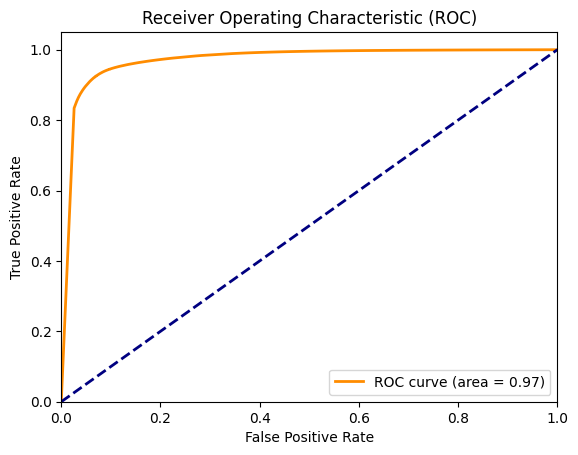

In [29]:
y_true = y_test.flatten()
y_score = y_pred.flatten()

fpr, tpr, _ = roc_curve(y_true, y_score)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Save the figure
plt.savefig(os.path.join(log_dir, 'roc.png'))

plt.show()


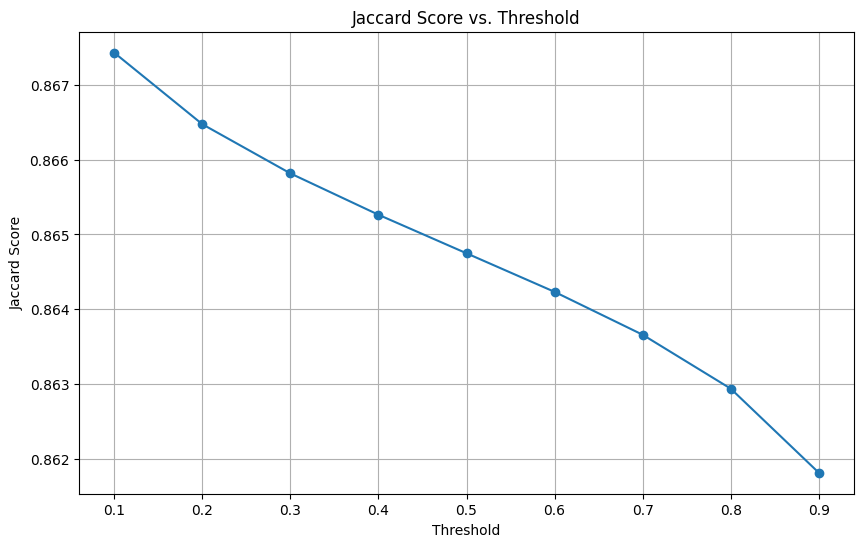

In [30]:
# Define your threshold values to evaluate
thresholds = np.linspace(0.1, 0.9, num=9)  # Adjust the range and step size as needed

# Initialize an empty list to store Jaccard scores
jaccard_scores = []

for threshold in thresholds:
    # Apply the threshold to the model's predictions
    thresholded_predictions = (y_score > threshold).astype(int)
    
    # Calculate the Jaccard score (IoU) for the thresholded predictions
    score = jaccard_score(y_true, thresholded_predictions)  # Adjust 'average' as needed
    
    jaccard_scores.append(score)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, jaccard_scores, marker='o', linestyle='-')
plt.title('Jaccard Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Jaccard Score')
plt.grid(True)

# Save the figure
plt.savefig(os.path.join(log_dir, 'threshold.png'))

plt.show()